# TOI-1130 photoTRADES

In [1]:
import numpy as np
import os
import sys
import glob
import time as timer
from astropy.time import Time

import matplotlib.pyplot as plt

Import `pytrades`

In [2]:
from pytrades import constants as cst
from pytrades import ancillary as anc
from pytrades import pytrades

set_unit_base = anc.set_unit_base

/home/malavolta/CODE/others/anaconda3/envs/pyorbit_trades/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set `rcParams` with my default values

In [3]:
anc.set_rcParams()

Define input and output folders

In [4]:
here_folder = os.path.abspath(".")

photometry_folder = os.path.join(here_folder, "photometry")
radial_velocities_folder = os.path.join(here_folder, "radial_velocities")
transit_times_folder = os.path.join(here_folder, "transit_times")

out_folder = os.path.join(here_folder, "output")
os.makedirs(out_folder, exist_ok=True)

map_out_folder = os.path.join(out_folder, "01_map")
os.makedirs(map_out_folder, exist_ok=True)

## Photometry

### CHEOPS

In [5]:
# 16 out of 17 CHEOPS lcs have been pre-detrended, one will be detrended during the analysis
def get_CHEOPS_data(cheops_path, n_harm=3):

    cheops_files = [
        "CHEOPS-PIPE_TOI-1130b_v01_CH_PR100031_TG040601_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v02_CH_PR100031_TG040801_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v03_CH_PR100031_TG040802_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v04_CH_PR100031_TG042201_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v05_CH_PR100031_TG044601_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v06_CH_PR100031_TG044602_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v07_CH_PR100031_TG052801_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v08_CH_PR100031_TG052901_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v09_CH_PR120053_TG004601_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v10_CH_PR120053_TG004602_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130b_v11_CH_PR120053_TG005101_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130c_v01_CH_PR100015_TG018001_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130c_v02_CH_PR100015_TG018101_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130c_v03_CH_PR100015_TG018201_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130c_v04_CH_PR100015_TG018301_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130c_v05_CH_PR100015_TG022801_V0200_detrended.dat",
        "CHEOPS-PIPE_TOI-1130c_v06_CH_PR120053_TG004701_V0200_normalized.dat", # not detrended
    ]
    ncheops = len(cheops_files)
    print("Number of files in path: {}".format(ncheops))

    cheops = {}
    trend_coeff = {}
    ancillary_coeff = {}
    n = 0

    for i, f in enumerate(cheops_files):
        print("\nLoading file {} with id {}".format(f, i))
        ff = os.path.join(cheops_path, f)
        visit = {}

        if "TOI-1130c_v06" in f:
            (time, flux, flux_err, xoff, yoff, bg, roll_angle, deltaT) = np.genfromtxt(
                ff, unpack=True
            )
            dx = anc.normalization_range(xoff)
            dx2 = dx * dx
            dy = anc.normalization_range(yoff)
            dy2 = dy * dy
            dxdy = dx * dy

            # ftrend = [1.002, 0.0] # const & linear==0
            ftrend = [1.0, 0.0]  # const & linear==0
            ancillary = {
                "dx": dx,
                "dx2": dx2,
                "dy": dy,
                "dy2": dy2,
                "dxdy": dxdy,
                "bg": anc.normalization_max(bg),
                # "deltaT": deltaT
            }
            harmonics = anc.angle_to_harmonics(roll_angle, n_harmonics=n_harm)
            for nn, hh in harmonics.items():
                ancillary[nn] = hh
            anc_coeff = [0.0] * len(ancillary)
        else:
            # ftrend = [1.0, 0.0] # const & linear==0
            ftrend = None
            time, flux, flux_err = np.genfromtxt(ff, usecols=(0, 1, 2), unpack=True)
            ancillary = None
            anc_coeff = None

        if ancillary is not None:
            print(ancillary.keys())

        visit = pytrades.set_photometry_portion(
            time,
            flux,
            flux_err,
            n_oversample=1,
            t_exp_d=60.0 * cst.sec2day,
            ancillary=ancillary,
        )

        cheops[n + i] = visit
        trend_coeff[n + i] = ftrend
        ancillary_coeff[n + i] = anc_coeff

    return cheops, trend_coeff, ancillary_coeff


# ==============================================================================================
cheops, cheops_trend_coeff, cheops_anc_coeff = get_CHEOPS_data(
    photometry_folder, n_harm=3
)
# ==============================================================================================

Number of files in path: 17

Loading file CHEOPS-PIPE_TOI-1130b_v01_CH_PR100031_TG040601_V0200_detrended.dat with id 0

Loading file CHEOPS-PIPE_TOI-1130b_v02_CH_PR100031_TG040801_V0200_detrended.dat with id 1

Loading file CHEOPS-PIPE_TOI-1130b_v03_CH_PR100031_TG040802_V0200_detrended.dat with id 2

Loading file CHEOPS-PIPE_TOI-1130b_v04_CH_PR100031_TG042201_V0200_detrended.dat with id 3

Loading file CHEOPS-PIPE_TOI-1130b_v05_CH_PR100031_TG044601_V0200_detrended.dat with id 4

Loading file CHEOPS-PIPE_TOI-1130b_v06_CH_PR100031_TG044602_V0200_detrended.dat with id 5

Loading file CHEOPS-PIPE_TOI-1130b_v07_CH_PR100031_TG052801_V0200_detrended.dat with id 6

Loading file CHEOPS-PIPE_TOI-1130b_v08_CH_PR100031_TG052901_V0200_detrended.dat with id 7

Loading file CHEOPS-PIPE_TOI-1130b_v09_CH_PR120053_TG004601_V0200_detrended.dat with id 8

Loading file CHEOPS-PIPE_TOI-1130b_v10_CH_PR120053_TG004602_V0200_detrended.dat with id 9

Loading file CHEOPS-PIPE_TOI-1130b_v11_CH_PR120053_TG005101_V

### TESS

In [6]:
def get_TESS_data(tess_path):

    tess_files = glob.glob(os.path.join(tess_path, "TOI-1130*_TESS_S*_*.dat"))
    tess_files += glob.glob(os.path.join(tess_path, "TOI-1130_TESS-S*_*.dat"))
    tess_files = np.sort(tess_files)
    ntess = len(tess_files)
    print("Number of files in path: {}".format(ntess))
    tess = {}
    trend_coeff = {}
    ancillary_coeff = {}
    n = 0
    for i, ff in enumerate(tess_files):
        print("\nLoading file {} with id {}".format(os.path.basename(ff), i))
        # ftrend = [1.0, 0.0] # const & linear==0
        ftrend = None
        visit = {}
        time, flux, flux_err = np.genfromtxt(ff, usecols=(0, 1, 2), unpack=True)
        # ndata = len(time)
        texp = np.median(np.diff(time))
        texp_s = int(texp * cst.day2sec) + 1
        nover = int(texp_s // 60) + 1
        print("t exp = {:.5f} d = {:d} s ==> n_over = {:d}".format(texp, texp_s, nover))

        visit = pytrades.set_photometry_portion(
            time, flux, flux_err, n_oversample=nover, t_exp_d=texp
        )

        tess[n + i] = visit
        trend_coeff[n + i] = ftrend
        ancillary_coeff[n + i] = None

    return tess, trend_coeff, ancillary_coeff


# =======================================================================
tess, tess_trend_coeff, tess_anc_coeff = get_TESS_data(photometry_folder)
# =======================================================================

Number of files in path: 19

Loading file TOI-1130_TESS-S67_b+184_texp20s.dat with id 0
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_b+185_texp20s.dat with id 1
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_b+186_texp20s.dat with id 2
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_b+188_texp20s.dat with id 3
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_b+189_texp20s.dat with id 4
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_c+125_texp20s.dat with id 5
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_c+126_texp20s.dat with id 6
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130_TESS-S67_c+127_texp20s.dat with id 7
t exp = 0.00023 d = 20 s ==> n_over = 1

Loading file TOI-1130b_TESS_S13_06.dat with id 8
t exp = 0.02083 d = 1800 s ==> n_over = 31

Loading file TOI-1130b_TESS_S27_01.dat with id 9
t exp = 0.00023 d = 20 s ==> 

### ASTEP+

In [7]:
def get_ASTEP_data(data_file, astep=None, trend_coeff=None, ancillary_coeff=None):

    if astep is None:
        astep = {}
        trend_coeff = {}
        ancillary_coeff = {}
        n = 0
    else:
        n = len(astep)

    ftrend = [1.0, 0.0, 0.0]  # const, linear, quadratic
    print("Loading file {} with id {}".format(os.path.basename(data_file), n + 1))
    visit = {}
    (time, flux, flux_err, dx, dy, fwhm, fwhmx, fwhmy, sky, airmass) = np.genfromtxt(
        data_file, unpack=True
    )
    texp = np.median(np.diff(time))
    texp_s = int(texp * cst.day2sec) + 1
    nover = int(texp_s // 60) + 1
    print("t exp = {:.5f} d = {:d} s ==> n_over = {:d}\n".format(texp, texp_s, nover))

    ancillary = {
        "dx": anc.normalization_standard(dx),
        "dy": anc.normalization_standard(dy),
        "fwhm": anc.normalization_standard(fwhm),
        "sky": anc.normalization_standard(sky),
    }
    visit = pytrades.set_photometry_portion(
        time, flux, flux_err, n_oversample=nover, t_exp_d=texp, ancillary=ancillary
    )

    astep[n] = visit
    trend_coeff[n] = ftrend
    ancillary_coeff[n] = [0.0] * len(ancillary)

    return astep, trend_coeff, ancillary_coeff


# =====================================================================================================

astep_list = [
    "TOI-1130.01_20230623_B_full.dat",
    "TOI-1130.01_20230623_R_full.dat",
    "TOI-1130.01_20230709_B_full.dat",
    "TOI-1130.01_20230709_R_full.dat",
    "TOI-1130.01_20230718_B_full.dat",
    "TOI-1130.01_20230718_R_full.dat",
    "TOI-1130.02_20230602_B_full.dat",
    "TOI-1130.02_20230602_R_full.dat",
    "TOI-1130.02_20230721_B_full.dat",
    "TOI-1130.02_20230721_R_full.dat",
]
astep_B, astep_B_trend_coeff, astep_B_anc_coeff = None, None, None
astep_R, astep_R_trend_coeff, astep_R_anc_coeff = None, None, None
for afile in astep_list:
    if "B_full.dat" in afile:
        astep_B, astep_B_trend_coeff, astep_B_anc_coeff = get_ASTEP_data(
            os.path.join(photometry_folder, afile),
            astep=astep_B,
            trend_coeff=astep_B_trend_coeff,
            ancillary_coeff=astep_B_anc_coeff,
        )
    if "R_full.dat" in afile:
        astep_R, astep_R_trend_coeff, astep_R_anc_coeff = get_ASTEP_data(
            os.path.join(photometry_folder, afile),
            astep=astep_R,
            trend_coeff=astep_R_trend_coeff,
            ancillary_coeff=astep_R_anc_coeff,
        )
# =====================================================================================================

Loading file TOI-1130.01_20230623_B_full.dat with id 1
t exp = 0.00073 d = 64 s ==> n_over = 2

Loading file TOI-1130.01_20230623_R_full.dat with id 1
t exp = 0.00033 d = 29 s ==> n_over = 1

Loading file TOI-1130.01_20230709_B_full.dat with id 2
t exp = 0.00072 d = 63 s ==> n_over = 2

Loading file TOI-1130.01_20230709_R_full.dat with id 2
t exp = 0.00033 d = 29 s ==> n_over = 1

Loading file TOI-1130.01_20230718_B_full.dat with id 3
t exp = 0.00072 d = 63 s ==> n_over = 2

Loading file TOI-1130.01_20230718_R_full.dat with id 3
t exp = 0.00033 d = 29 s ==> n_over = 1

Loading file TOI-1130.02_20230602_B_full.dat with id 4
t exp = 0.00073 d = 64 s ==> n_over = 2

Loading file TOI-1130.02_20230602_R_full.dat with id 4
t exp = 0.00033 d = 29 s ==> n_over = 1

Loading file TOI-1130.02_20230721_B_full.dat with id 5
t exp = 0.00073 d = 64 s ==> n_over = 2

Loading file TOI-1130.02_20230721_R_full.dat with id 5
t exp = 0.00033 d = 29 s ==> n_over = 1



## Radial Velocities

### CHIRON

In [8]:
chiron_file = os.path.join(radial_velocities_folder, "Huang2020_obsRV.dat")
t_rv_chiron, rv_chiron, erv_chiron = np.genfromtxt(chiron_file, unpack=True)
chiron = {"time": t_rv_chiron, "rv": rv_chiron, "rv_err": erv_chiron}

### HARPS

In [9]:
harps_file = os.path.join(radial_velocities_folder, "Table_A1_RV_HARPS.dat")
t_rv_harps, rv_harps, erv_harps = np.genfromtxt(
    harps_file, usecols=(0, 1, 2), unpack=True
)
harps = {"time": t_rv_harps, "rv": rv_harps, "rv_err": erv_harps}

### PFS

In [10]:
pfs_file = os.path.join(radial_velocities_folder, "Table_A2_RV_PFS.dat")
t_rv_pfs, rv_pfs, erv_pfs = np.genfromtxt(pfs_file, usecols=(0, 1, 2), unpack=True)
pfs = {"time": t_rv_pfs, "rv": rv_pfs, "rv_err": erv_pfs}

## Transit times

### planet b

In [11]:
Tref_b, Pref_b = [2376.5021787, 0.0194616], [
    4.0788975,
    0.0000984,
]  # from previous PyORBIT analysis
T0b_file = os.path.join(transit_times_folder, "ground-based_T0s_b.txt")
T0b, eT0b, src_b = np.genfromtxt(T0b_file, unpack=True)
T0b -= cst.btjd
epo_b = anc.compute_epoch(Tref_b[0], Pref_b[0], T0b)

### planet c

In [12]:
Tref_c, Pref_c = [2083.7378060, 0.0017103], [
    8.3495010,
    0.0000401,
]  # from previous PyORBIT analysis
T0c_file = os.path.join(transit_times_folder, "ground-based_T0s_c.txt")
T0c, eT0c, src_c = np.genfromtxt(T0c_file, unpack=True)
T0c -= cst.btjd
epo_c = anc.compute_epoch(Tref_c[0], Pref_c[0], T0c)

## Set `pytrades` configuration

In [13]:
t_epoch = 1657.0
t_start = t_epoch
t_end = Time("2023-08-30T00:00:00", format="isot", scale="tdb").jd - cst.btjd
t_int = t_end - t_start

print("total integration time: {} days".format(t_int))

body_names = ["star", "b", "c"]
n_body = len(
    body_names
)  # number of bodies (NOT PLANETS) in the system, that is star + planets

total integration time: 1529.5 days


Init the `photoTRADES` object

In [14]:
sim = pytrades.PhotoTRADES(
    n_body,
    t_epoch,
    t_start,
    t_int,
    duration_check=1,
    encounter_check=True,
    do_hill_check=False,
    amd_hill_check=False,
    rv_res_gls=False,
)

Add photometry

In [15]:
sim.add_photometry("cheops", cheops, cheops_trend_coeff, anc_coeff=cheops_anc_coeff)
sim.add_photometry("tess", tess, tess_trend_coeff, anc_coeff=tess_anc_coeff)
sim.add_photometry("astep_B", astep_B, astep_B_trend_coeff, anc_coeff=astep_B_anc_coeff)
sim.add_photometry("astep_R", astep_R, astep_R_trend_coeff, anc_coeff=astep_R_anc_coeff)

Add radial velocities

In [29]:

#sim.add_radial_velocity("CHIRON", chiron, 1)  # chiron will have the source id 1
#sim.add_radial_velocity("HARPS", harps, 2)  # HARPS the id 2
#sim.add_radial_velocity("PFS", pfs, 3)  # PFS the id 3
#sim.set_radial_velocity_sorting()  # sort the radial velocities\

Add transit times

In [17]:
#body_id = 2
#sim.add_linear_ephem(body_id, Tref_b, Pref_b)
#sim.add_transits(body_id, T0b, eT0b, epo=epo_b, sources=src_b)

#body_id = 3
#sim.add_linear_ephem(body_id, Tref_c, Pref_c)
#sim.add_transits(body_id, T0c, eT0c, epo=epo_c, sources=src_c)

Required to update `n_data` variable

In [18]:
sim.update_n_data()

Let's define the system parameters

In [19]:
M_msun = np.array(
    [0.745059, 19.833346 * cst.Mears, 335.603435 * cst.Mears]
)  # Masses in Solar unit
R_rsun = np.array(
    [0.697470, 3.657000 * cst.Rears, 12.983016 * cst.Rears]
)  # Radii in Solar unit
P_day = np.array([0.0, 4.074554, 8.350190])  # Periods in days
ecc_val = np.array([0.0, 0.0521624, 0.039773])  # eccentricities
argp_deg = np.array([0.0, 141.11112, 182.502357])  # argument of pericenters in degrees
mA_deg = np.array([0.0, 159.696701, 233.068994])  # mean anonalies in degrees
inc_deg = np.array([0.0, 87.494901, 87.613475])  # inclinations in degrees
lN_deg = np.array([0.0, 180.0, 179.993043])  # longitude of ascending nodes in degrees

In [20]:
sim.add_default_physical_parameters(
    M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg
)

### Try the functions to simulate transit times, radial velocities, and photometry

Run the simulation as splitted in transit times + radial velocities ...

In [21]:
(
    time_steps,
    orbits,
    transits,
    durations,
    lambda_rm,
    kep_elem,
    body_flag,
    rv_sim,
    stable,
) = sim.orbital_parameters_to_transits(
    M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg
)

# extract the transits times for each body/planet
sim_transits = sim.get_simulated_transits(transits, body_flag)

KeyError: 2

... and photometry (`pytransit` uses `numba-jit` acceleration and the first time it will be very slow, then the computational time will be greatly reduced)

In [22]:
ld_vals = {
    "cheops": np.array([0.300833, 0.407615]),
    "tess": np.array([0.384825, 0.322173]),
    "astep_B": np.array([0.801253, -0.188036]),
    "astep_R": np.array([0.702927, -0.260307]),
}
ld_quads = {k: v.copy() for k, v in ld_vals.items()}

ld_sigmas = {
    "cheops": np.array([0.108117, 0.131881]),
    "tess": np.array([0.130181, 0.164750]),
    "astep_B": np.array([0.139823, 0.175295]),
    "astep_R": np.array([0.138781, 0.171376]),
}


phot_sim_v0 = sim.get_simulate_flux(
    R_rsun, ld_quads, transits, durations, body_flag, kep_elem,
    time_key="time"
)

Or we can get only the observables as photometry (without detrending), radial velocities, and transit times

In [23]:
phot_sim_v0, rv_sim, sim_transits = sim.full_photodyn(
    M_msun, R_rsun, P_day, ecc_val, argp_deg, mA_deg, inc_deg, lN_deg, ld_quads
)

Try to plot as it the O-C, the RV, and the photometry

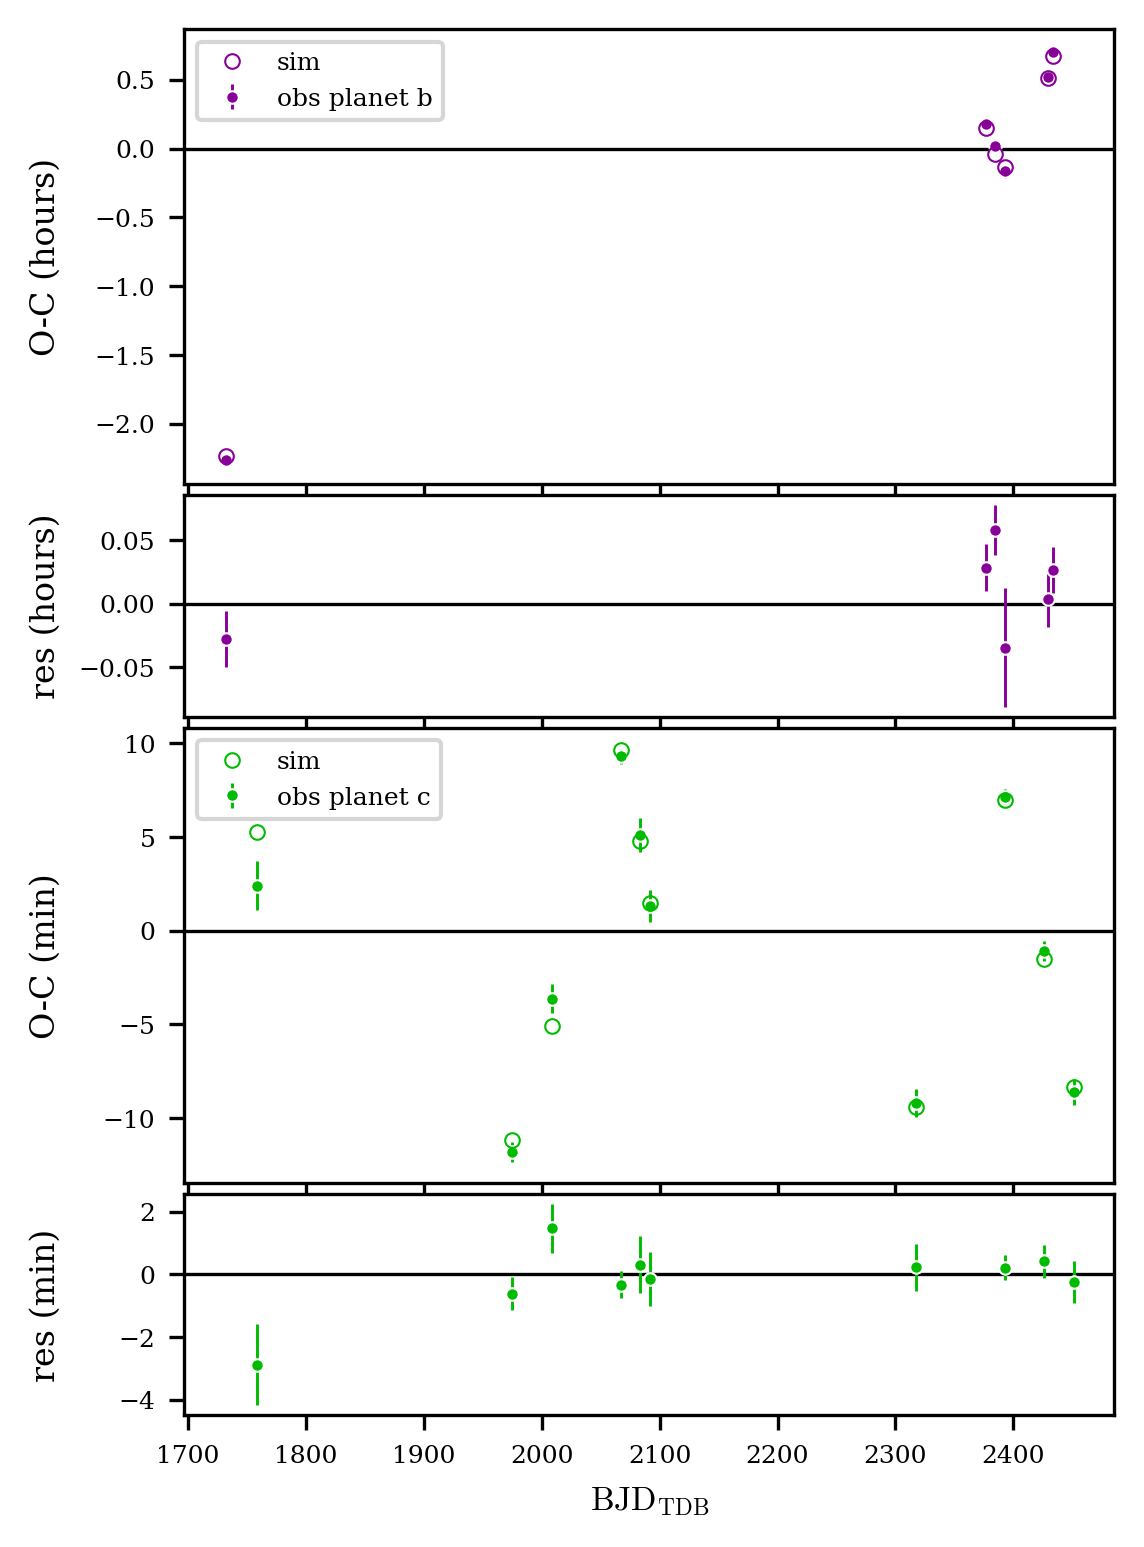

In [24]:
sim.plot_oc(
    sim_transits,
    {2: "b", 3: "c"}, # map the planet id with letter
    figsize=(4, 6),
    show_plot=True,
    output_folder=map_out_folder,
)


gammaRV =  {1: -9567.738913, 2: -8022.956374, 3: 39.791098}
jitterRV =  {1: 1.082326, 2: 2.48303, 3: 2.484372}


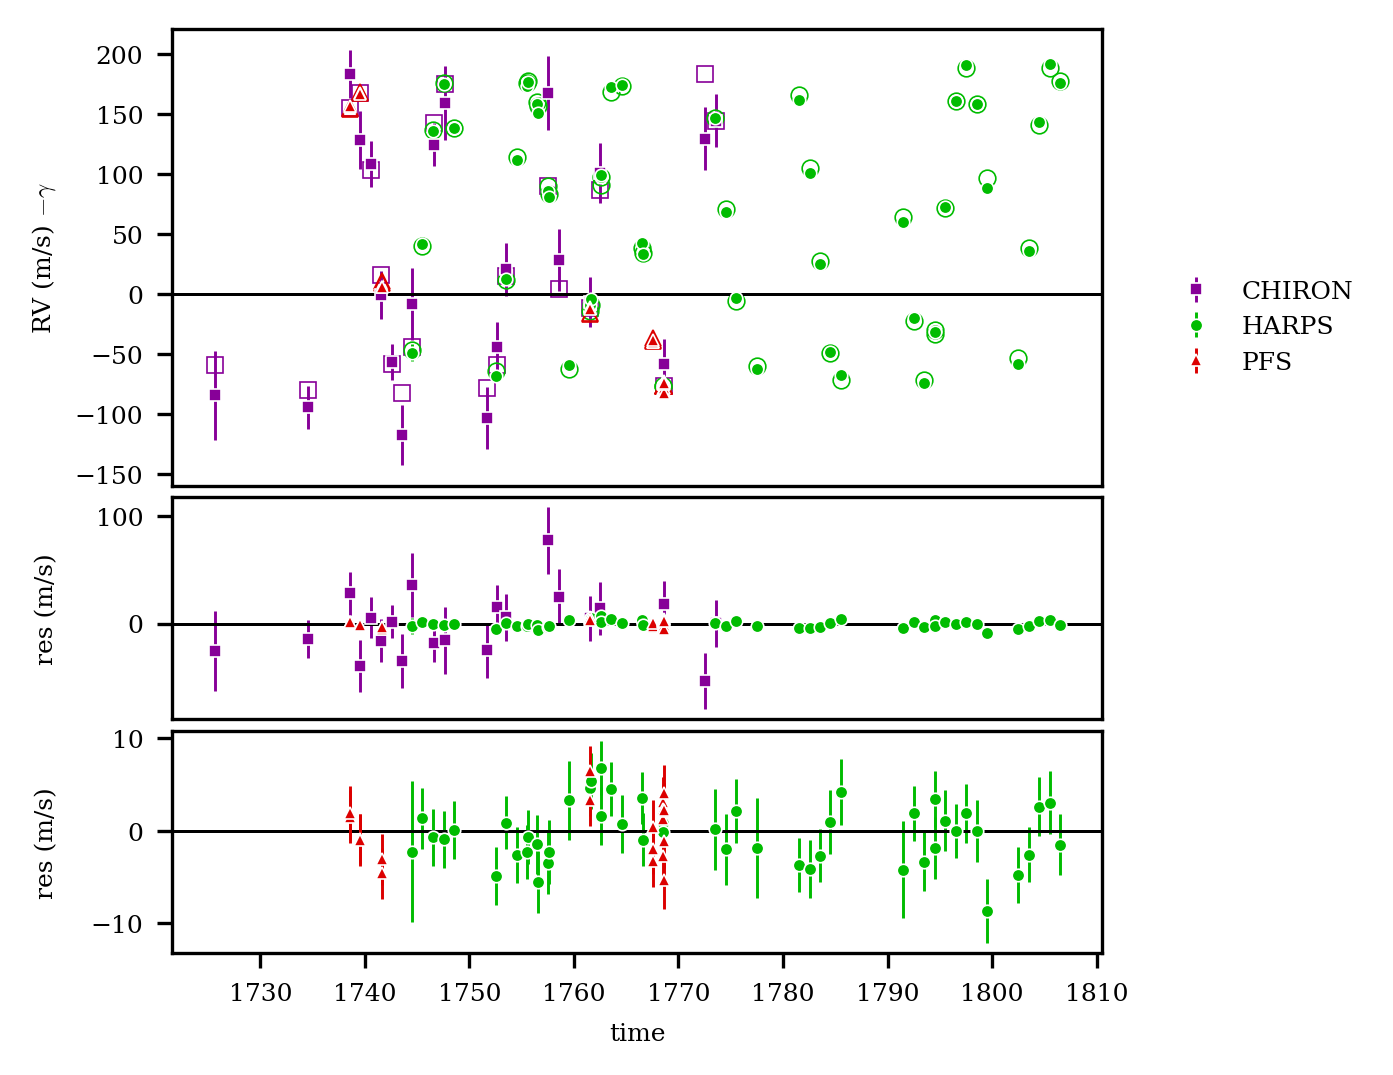

In [25]:
gamma_rv = {
    "chiron".upper(): -9567.738913,
    "harps".upper(): -8022.956374,
    "pfs".upper(): 39.791098,
}
gammas = {irv: gamma_rv[k] for k, irv in sim.id_radial_velocity.items()}
print("gammaRV = ", gammas)

jitter_rv = {
    "chiron".upper(): 1.082326,
    "harps".upper(): 2.483030,
    "pfs".upper(): 2.484372,
}
jitters = {irv: jitter_rv[k] for k, irv in sim.id_radial_velocity.items()}
print("jitterRV = ", jitters)

markers = {
    "chiron".upper(): "s",
    "harps".upper(): "o",
    "pfs".upper(): "^",
}

rv_coeff = [0.48561]

sim.plot_rv(
    rv_sim,
    gammas,
    jitters,
    markers,
    rv_coeff,
    figsize=(4, 4),
    print_rv=False,
    show_plot=True,
    output_folder=map_out_folder,
    remove_dataset=["chiron"],
)


In [24]:
sim.plot_photometry(
    phot_sim_v0,
    mod_photometry=None,
    trend_photometry=None,
    show_plot=False, # change to True to see the plot
    output_folder=None,
)

However, the photometry of CHEOPS last lc has not been detrendend, neither the ASTEP+ ones.

In [26]:
phot_trend_coeff = dict(sim.photometry_flux_trend_coeff)
anc_coeff = dict(sim.ancillary_coeff)

# CHEOPS LAST LC #17 --> id 16
phot_trend_coeff["cheops"][16] = [1.004287, -0.001512]  # constant and linear trend

anc_coeff["cheops"][16] = [
    0.000795,
    0.000702,
    -0.000530,
    0.000340,
    -0.000513,
    -0.000861,
    0.003525,
    -0.001379,
    0.001583,
    -0.001610,
    0.000233,
    -0.000661,
]

phot_trend_coeff["astep_B"][0] = [1.006616, -0.061694, 0.161411]
phot_trend_coeff["astep_B"][1] = [1.003577, 0.018899, -0.125315]
phot_trend_coeff["astep_B"][2] = [1.000407, -0.009171, 0.036907]
phot_trend_coeff["astep_B"][3] = [0.999339, 0.012278, -0.010768]
phot_trend_coeff["astep_B"][4] = [0.999843, 0.002899, 0.002714]

phot_trend_coeff["astep_R"][0] = [1.005253, -0.035509, 0.145163]
phot_trend_coeff["astep_R"][1] = [1.006931, -0.027714, -0.000532]
phot_trend_coeff["astep_R"][2] = [0.994932, 0.057838, -0.100811]
phot_trend_coeff["astep_R"][3] = [0.998506, 0.047939, -0.183163]
phot_trend_coeff["astep_R"][4] = [0.998521, 0.022137, -0.045479]

# print("\nflux/time trend coefficients")
# for kp, pt in phot_trend_coeff.items():
#     for kt, trend in pt.items():
#         print(kp, kt, trend)

anc_coeff["astep_B"][0] = [
    -0.000147,
    0.000349,
    0.000335,
    0.000128,
]
anc_coeff["astep_B"][1] = [
    -0.000449,
    -0.000306,
    -0.000315,
    0.001147,
]
anc_coeff["astep_B"][2] = [
    -0.000491,
    -0.001006,
    0.000223,
    -0.000067,
]
anc_coeff["astep_B"][3] = [
    0.000472,
    0.000011,
    0.000109,
    -0.001140,
]
anc_coeff["astep_B"][4] = [
    0.000140,
    -0.000021,
    0.000367,
    -0.000567,
]

anc_coeff["astep_R"][0] = [
    0.000213,
    0.000146,
    0.000639,
    -0.000080,
]
anc_coeff["astep_R"][1] = [
    -0.000099,
    -0.000080,
    0.000233,
    -0.000896,
]
anc_coeff["astep_R"][2] = [
    -0.000382,
    0.000459,
    0.000165,
    0.000138,
]
anc_coeff["astep_R"][3] = [
    -0.000164,
    -0.000248,
    0.000012,
    0.000132,
]
anc_coeff["astep_R"][4] = [
    0.000192,
    -0.000114,
    -0.000216,
    0.000438,
]

# print("\nancillary trend coefficients")
# for kp, pt in anc_coeff.items():
#     for kt, trend in pt.items():
#         print(kp, kt, trend)


sim_photometry, sim_trend = pytrades.get_photometry_full_trend(
    sim.photometry, phot_sim_v0, phot_trend_coeff, anc_coeff
)

In [27]:
sim.plot_photometry(
    sim_photometry,
    mod_photometry=phot_sim_v0,
    trend_photometry=sim_trend,
    show_plot=False,
    output_folder=map_out_folder,
)

In [28]:
# for kphot, phot in sim_photometry.items():
#     print(kphot)
#     for klc, sim_flux in phot.items():
#         print(klc)
#         t = sim.photometry[kphot][klc]["time"]
#         print("time len ",len(t), ", simulated flux len ",len(sim_flux))
#         print("obs photometry stored keys: ", sim.photometry[kphot][klc].keys())